# Instance Segmentation Visualization

Notebook adapted from tutorial: [link](https://github.com/open-mmlab/mmdetection/blob/main/demo/MMDet_InstanceSeg_Tutorial.ipynb).

In this notebook, we will create interactive visualizations for three models tested in the final project:
- Mask-RCNN
- QueryInst
- Mask2Former

In [1]:
# load packages
import os 
import json
import numpy as np
import matplotlib.pyplot as plt
import skimage

import torch 
import torch.nn as nn 

import mmcv
import mmengine
from mmdet.apis import init_detector, inference_detector
from mmdet.utils import register_all_modules
from mmdet.registry import VISUALIZERS

In [2]:
# verify cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # use single gpu for inference
print(device)

cuda:0


In [3]:
# define storage path
test_img_path = "/n/pehlevan_lab/Everyone/deepfashion2/raw/test/"

### 0. Utils

In [153]:
# read ground truth
def load_gt(path: str, idx: str, width: int, height: int): 
    """
    load annotation ground truth by index
    :param path: path to read the annotations from (typically form test)
    :param idx: the index from the image
    :param width, height: the width and height of the image 
    :return: (bboxes, masks, labels)
    """
    anno_path = os.path.join(path, idx + ".json")
    with open(anno_path, 'r') as f:
        temp = json.loads(f.read())
        
        bboxes, masks, labels = [], [], []
        
        for i in temp:
            if i == 'source' or i == 'pair_id': 
                continue
            else:
                # get bbox 
                box = temp[i]['bounding_box']
                bbox = box
                bboxes.append(bbox)
                
                # get masks
                seg = temp[i]['segmentation']
                mask = torch.zeros((width, height), dtype=torch.int)
                for poly in seg:
                    # for annotation with floating point segments, need capping
                    all_x = poly[0::2]
                    all_y = poly[1::2]
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    rr, cc = [min(y, height - 1) for y in rr], [
                        min(x, width - 1) for x in cc
                    ]  # for floating points, out of bounds issue
                    mask[rr, cc] = 1
                    # break  # * note that only the first polygon is processed. qualitative difference
                masks.append(mask.unsqueeze(0))
                
                # get labels 
                labels.append(temp[i]["category_id"] - 1)  # we reindex when parsing
    
        # parse to torch format
        bboxes = torch.as_tensor(bboxes)
        masks = torch.cat(masks, axis=0).bool()
        labels = torch.as_tensor(labels)
        
        return bboxes, masks, labels


In [176]:
# select index
img_idx = "132661" # shop (a very interesting example of identifying pants...)
img_idx = "163590" # shop 
img_idx = "137962" # shop (this one looks like a good example)

img_idx = "010572" # user (incorrectly identifying pants!)
img_idx = "092660" # user (a good example)
img_idx = "147862" # user

# img_idx = "024132" # coco small & viewpoint = frontal
# img_idx = "028251" # coco small & viewpoint = frontal, an interesting example 
# img_idx = "029535" # also interesting
# img_idx = "188322" # uninteresting

# img_idx = "010572" 
# img_idx = "065235"
# # img_idx = "120055"
# img_idx = "116037"

# # occlusion 3
# img_idx = "180218"
# img_idx = "010910" # legs ...
# img_idx = "105222"

# # random stuffs
# img_idx = "000228" # pants
# img_idx = "003720"

### 1. Mask RCNN

In [150]:
# load model
model_name = "mask-rcnn_r101_fpn_2x"
config_file = f'{model_name}.py'
# Setup a checkpoint file to load
checkpoint_file = f"/n/pehlevan_lab/Users/shengy/fashion/work_dir_full/{model_name}/epoch_24.pth"

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
mask_rcnn = init_detector(config_file, checkpoint_file, device=device)

# setup visualizer
visualizer = VISUALIZERS.build(mask_rcnn.cfg.visualizer) 
visualizer.dataset_meta = mask_rcnn.dataset_meta

# force a particular color pallete
color_palette = mask_rcnn.dataset_meta['palette']
visualizer.text_color = color_palette
visualizer.bbox_color = color_palette
visualizer.mask_color = color_palette


Loads checkpoint by local backend from path: /n/pehlevan_lab/Users/shengy/fashion/work_dir_full/mask-rcnn_r101_fpn_2x/epoch_24.pth


/n/home02/shengy/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [177]:
# read image
# img_idx = "001662"
img_path = os.path.join(test_img_path, "image", img_idx + '.jpg')

# get prediction
image = mmcv.imread(img_path, channel_order='rgb')
result = inference_detector(mask_rcnn, image)

# get ground truth
gt_bboxes, gt_masks, gt_labels = load_gt(os.path.join(test_img_path, "annos"), img_idx, image.shape[0], image.shape[1])

# append gt to result
result.gt_instances.bboxes = gt_bboxes
result.gt_instances.masks = gt_masks
result.gt_instances.labels = gt_labels


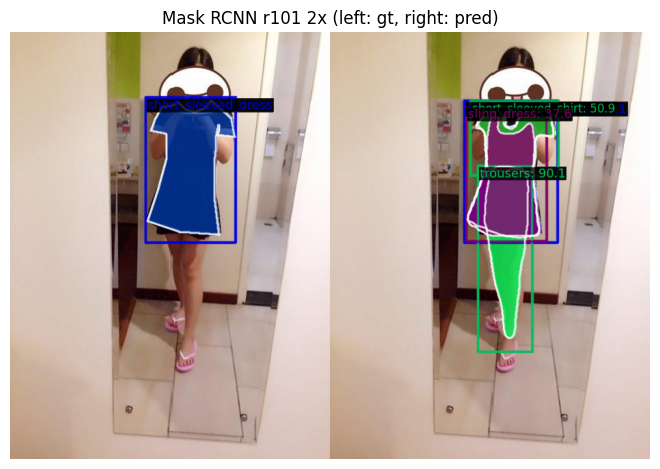

In [179]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt=True,
    wait_time=0,
)

fig = visualizer.show()
fig.axes[0].set_title("Mask RCNN r101 2x (left: gt, right: pred)")
# fig
fig.savefig(f"figs/mask-rcnn_{img_idx}.pdf", dpi=100, facecolor='white', bbox_inches='tight')
fig

### 2. QueryInst

In [25]:
# load model
model_name = "queryinst_r101_fpn_1x_coco"
config_file = f'{model_name}.py'
# Setup a checkpoint file to load
checkpoint_file = f"/n/pehlevan_lab/Users/shengy/fashion/work_dir/{model_name}/epoch_12.pth"

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
query_inst = init_detector(config_file, checkpoint_file, device=device)

# setup visualizer
visualizer = VISUALIZERS.build(query_inst.cfg.visualizer) 
visualizer.dataset_meta = query_inst.dataset_meta

# force a particular color pallete
color_palette = query_inst.dataset_meta['palette']
visualizer.text_color = color_palette
visualizer.bbox_color = color_palette
visualizer.mask_color = color_palette


Loads checkpoint by local backend from path: /n/pehlevan_lab/Users/shengy/fashion/work_dir/queryinst_r101_fpn_1x_coco/epoch_12.pth


/n/home02/shengy/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [180]:
# read image
# img_idx = "001662"
img_path = os.path.join(test_img_path, "image", img_idx + '.jpg')

# get prediction
image = mmcv.imread(img_path, channel_order='rgb')
result = inference_detector(query_inst, image)

# get ground truth
gt_bboxes, gt_masks, gt_labels = load_gt(os.path.join(test_img_path, "annos"), img_idx, image.shape[0], image.shape[1])

# append gt to result
result.gt_instances.bboxes = gt_bboxes
result.gt_instances.masks = gt_masks
result.gt_instances.labels = gt_labels


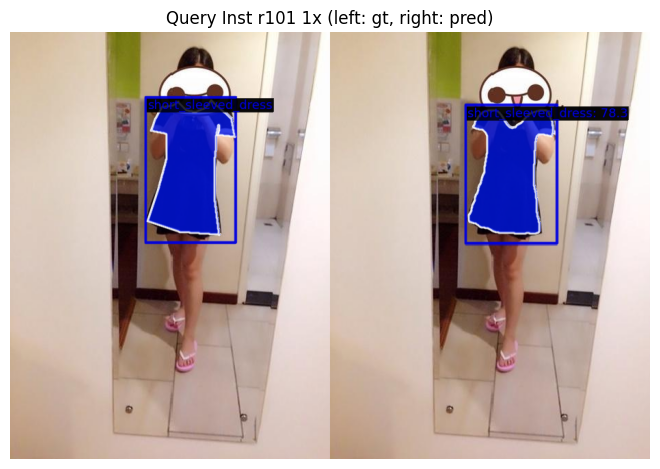

In [181]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt=True,
    wait_time=0,
)

fig = visualizer.show()
fig.axes[0].set_title("Query Inst r101 1x (left: gt, right: pred)")
# fig
fig.savefig(f"figs/query_inst_{img_idx}.pdf", dpi=100, facecolor='white', bbox_inches='tight')
fig

### 3. Mask2Former

In [28]:
# load model
model_name = "mask2former_r101_1x"
config_file = f'{model_name}.py'
# Setup a checkpoint file to load
checkpoint_file = f"/n/pehlevan_lab/Users/shengy/fashion/work_dir/{model_name}/epoch_12.pth"

# register all modules in mmdet into the registries
register_all_modules()

# build the model from a config file and a checkpoint file
mask2former = init_detector(config_file, checkpoint_file, device=device)

# setup visualizer
visualizer = VISUALIZERS.build(mask2former.cfg.visualizer) 
visualizer.dataset_meta = mask2former.dataset_meta

# force a particular color pallete
color_palette = mask2former.dataset_meta['palette']
visualizer.text_color = color_palette
visualizer.bbox_color = color_palette
visualizer.mask_color = color_palette


Loads checkpoint by local backend from path: /n/pehlevan_lab/Users/shengy/fashion/work_dir/mask2former_r101_1x/epoch_12.pth


/n/home02/shengy/anaconda3/envs/openmmlab/lib/python3.8/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmdet.visualization.local_visualizer.DetLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


In [182]:
# read image
# img_idx = "001662"
img_path = os.path.join(test_img_path, "image", img_idx + '.jpg')

# get prediction
image = mmcv.imread(img_path, channel_order='rgb')
result = inference_detector(mask2former, image)

# get ground truth
gt_bboxes, gt_masks, gt_labels = load_gt(os.path.join(test_img_path, "annos"), img_idx, image.shape[0], image.shape[1])

# append gt to result
result.gt_instances.bboxes = gt_bboxes
result.gt_instances.masks = gt_masks
result.gt_instances.labels = gt_labels


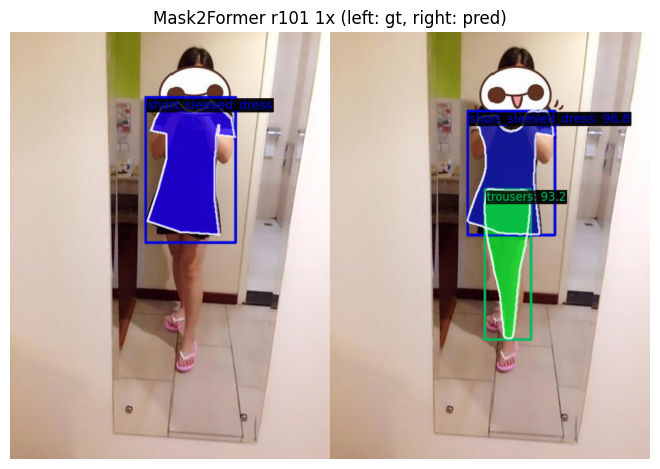

In [183]:
# show the results
visualizer.add_datasample(
    'result',
    image,
    data_sample=result,
    draw_gt=True,
    wait_time=0,
)

fig = visualizer.show()
fig.axes[0].set_title("Mask2Former r101 1x (left: gt, right: pred)")
# fig
fig.savefig(f"figs/mask2former_{img_idx}.pdf", dpi=100, facecolor='white', bbox_inches='tight')
fig